In [1]:
import os

import torch
import torchvision

from segwork.data import DroneDataset

In [2]:
# dataset from notebook
dataset = DroneDataset( 
    root = os.path.join(os.pardir, 'data', 'semantic_drone_dataset'), 
    transform=torchvision.transforms.ToTensor(),
    target_transform = torchvision.transforms.PILToTensor())
    

## Dataset Visualization

In [3]:
dataset.mask_colors

{(0, 0, 0): 'default',
 (128, 64, 128): 'paved-area',
 (130, 76, 0): 'dirt',
 (0, 102, 0): 'grass',
 (112, 103, 87): 'gravel',
 (28, 42, 168): 'water',
 (48, 41, 30): 'rocks',
 (0, 50, 89): 'pool',
 (107, 142, 35): 'vegetation',
 (70, 70, 70): 'roof',
 (102, 102, 156): 'wall',
 (254, 228, 12): 'window',
 (254, 148, 12): 'door',
 (190, 153, 153): 'fence',
 (153, 153, 153): 'fence-pole',
 (255, 22, 96): 'person',
 (102, 51, 0): 'dog',
 (9, 143, 150): 'car',
 (119, 11, 32): 'bicycle',
 (51, 51, 0): 'tree',
 (190, 250, 190): 'bald-tree',
 (112, 150, 146): 'ar-marker',
 (2, 135, 115): 'obstacle',
 (255, 0, 0): 'conflicting'}

Image resolution torch.Size([4000, 6000])


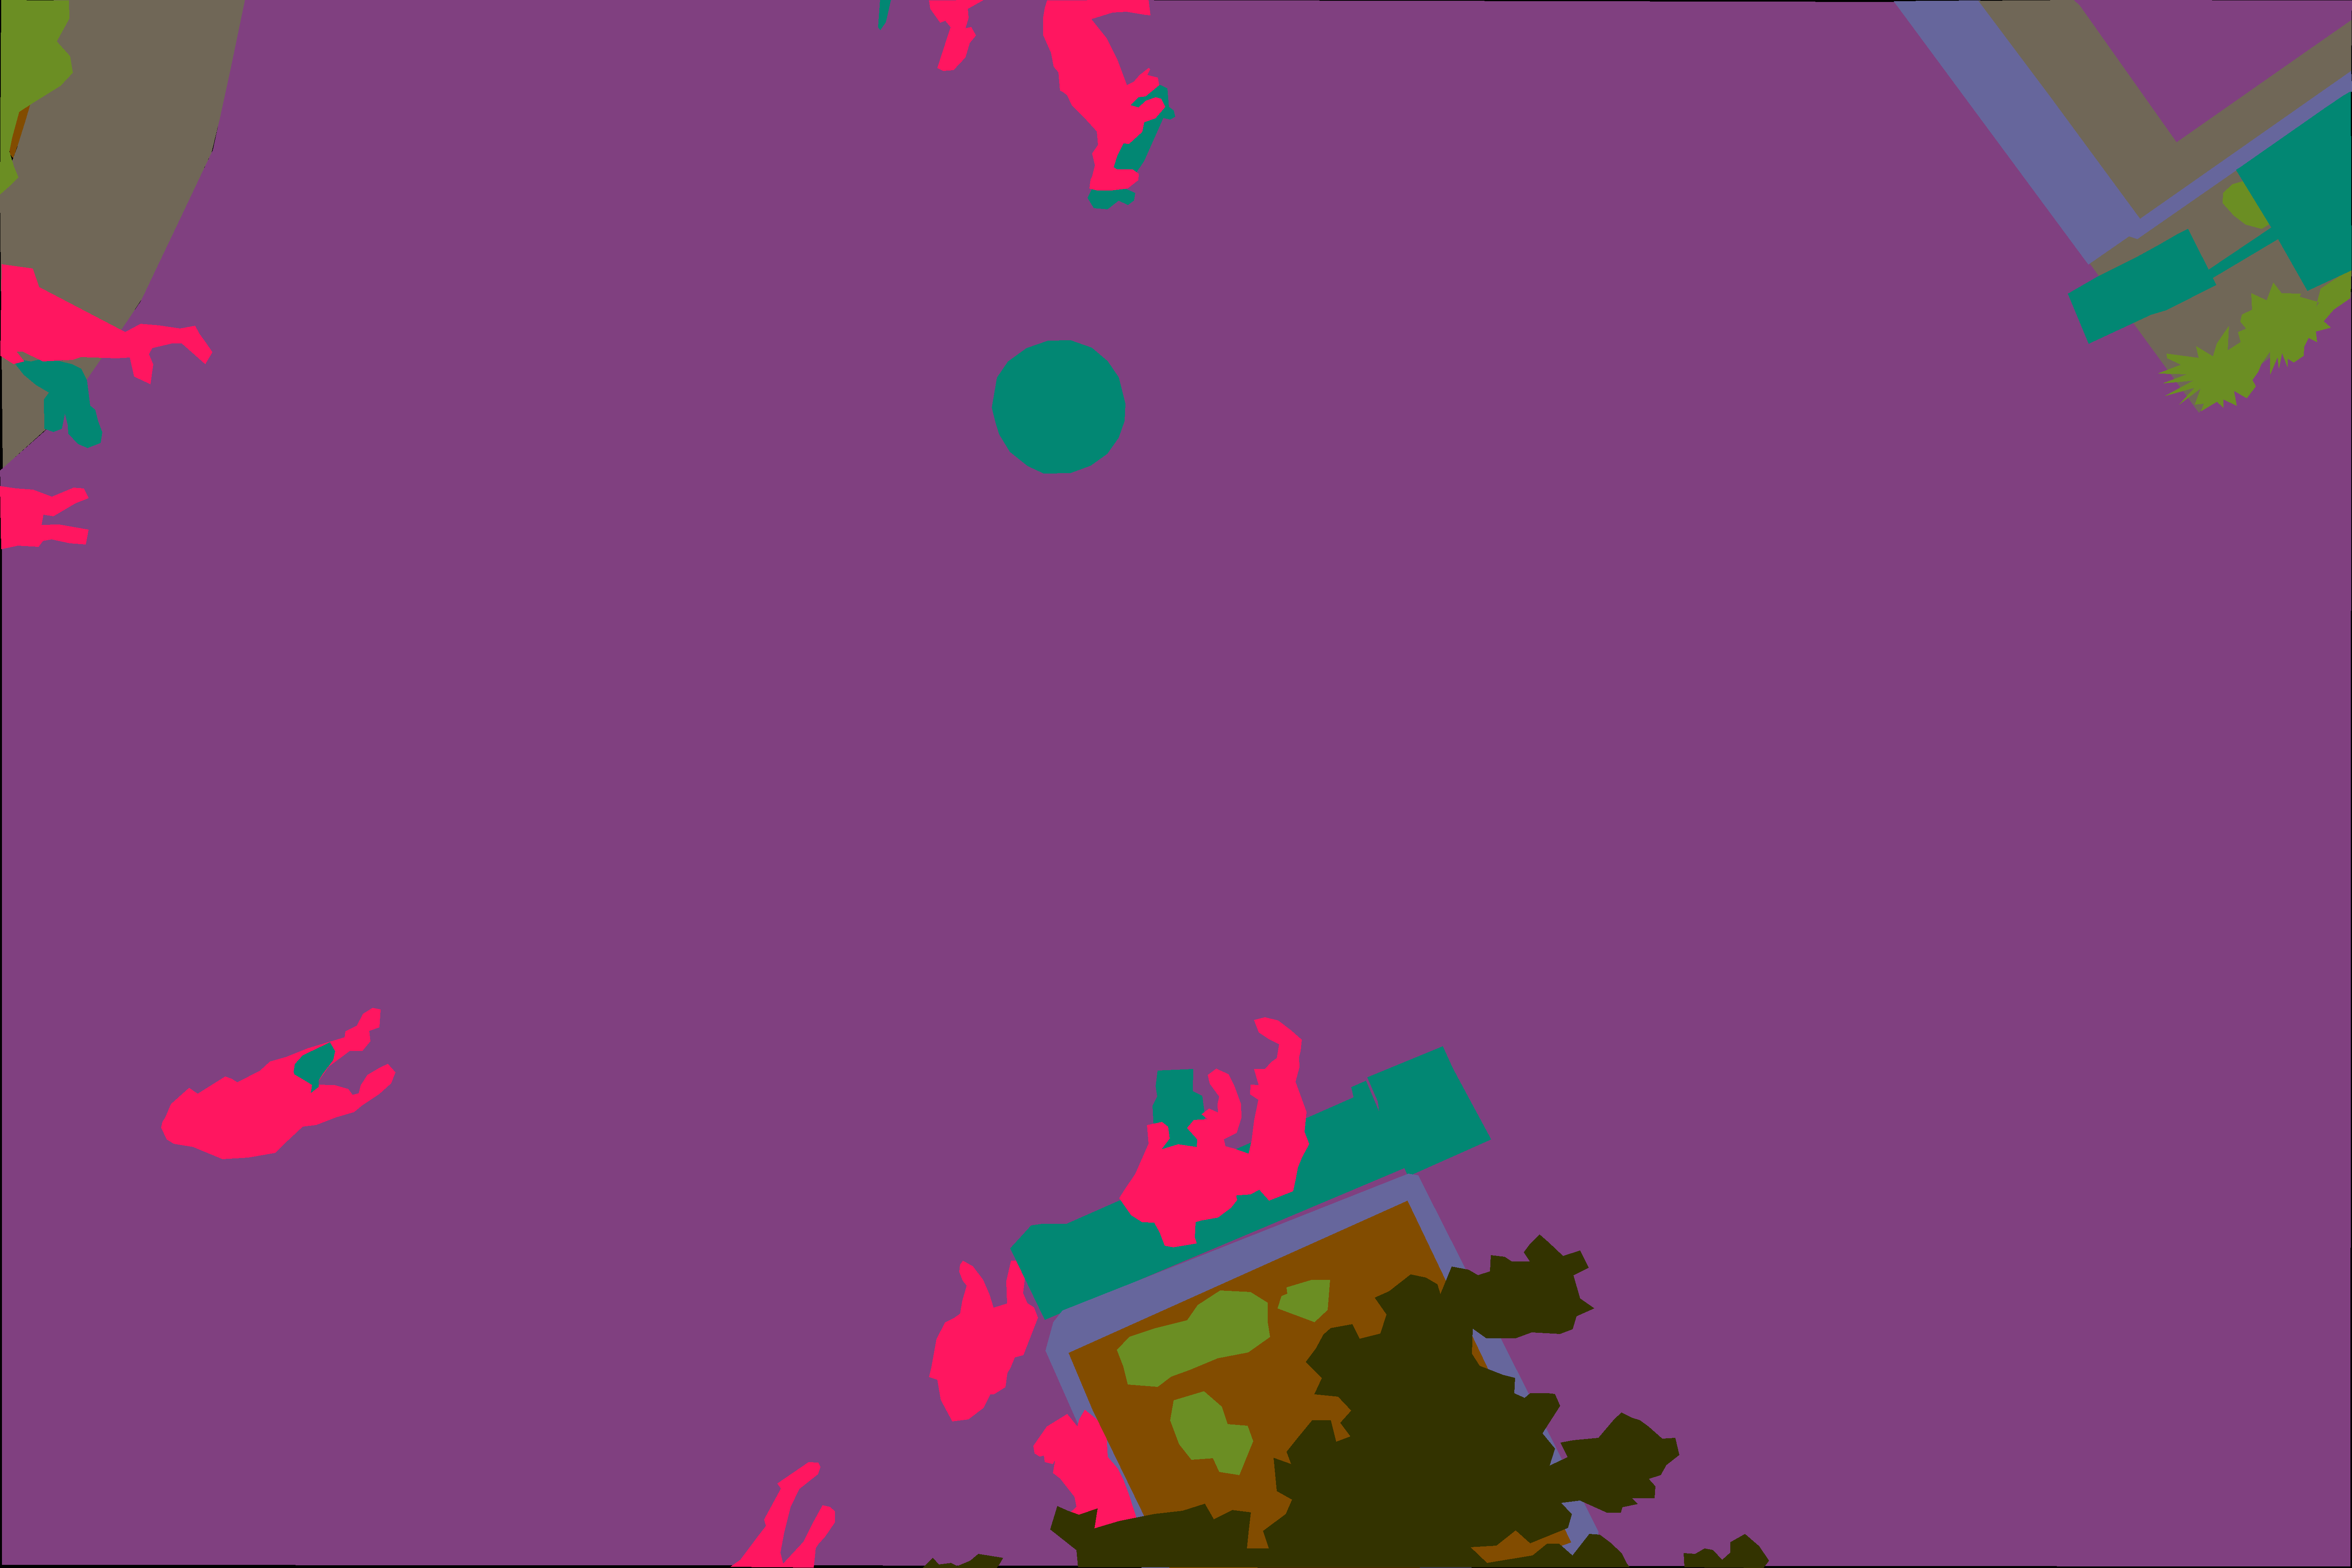

In [5]:
import torchvision.transforms as T
image, label = dataset[0]
print(f'Image resolution {image.size()[-2:]}')

# Watch label
transform = T.ToPILImage()
mask_png = transform(label)
mask_png

### Generate digestable segmentation mask
From PNG mask to numpy segmentation mask

In [1]:
from pathlib import Path

import numpy as np
from tqdm import tqdm 
import torch
import torchvision

from segwork.data.augmentations import ColorMasktoIndexMask, IndexMasktoColorMask 
from segwork.data import DroneDataset

In [2]:
dataset = DroneDataset( 
    root = os.path.join(os.pardir, 'data', 'semantic_drone_dataset'),
    target_transform = torchvision.transforms.PILToTensor())

In [3]:
#  Get color mask
_ , color_mask = dataset[0]
print(color_mask.size())

# Hard process, it takes on avg 10s
transform = ColorMasktoIndexMask(colors=dataset.mask_colors_index)
index_mask = transform(color_mask)
index_mask.size()


torch.Size([3, 4000, 6000])


torch.Size([4000, 6000])

torch.Size([4000, 6000])


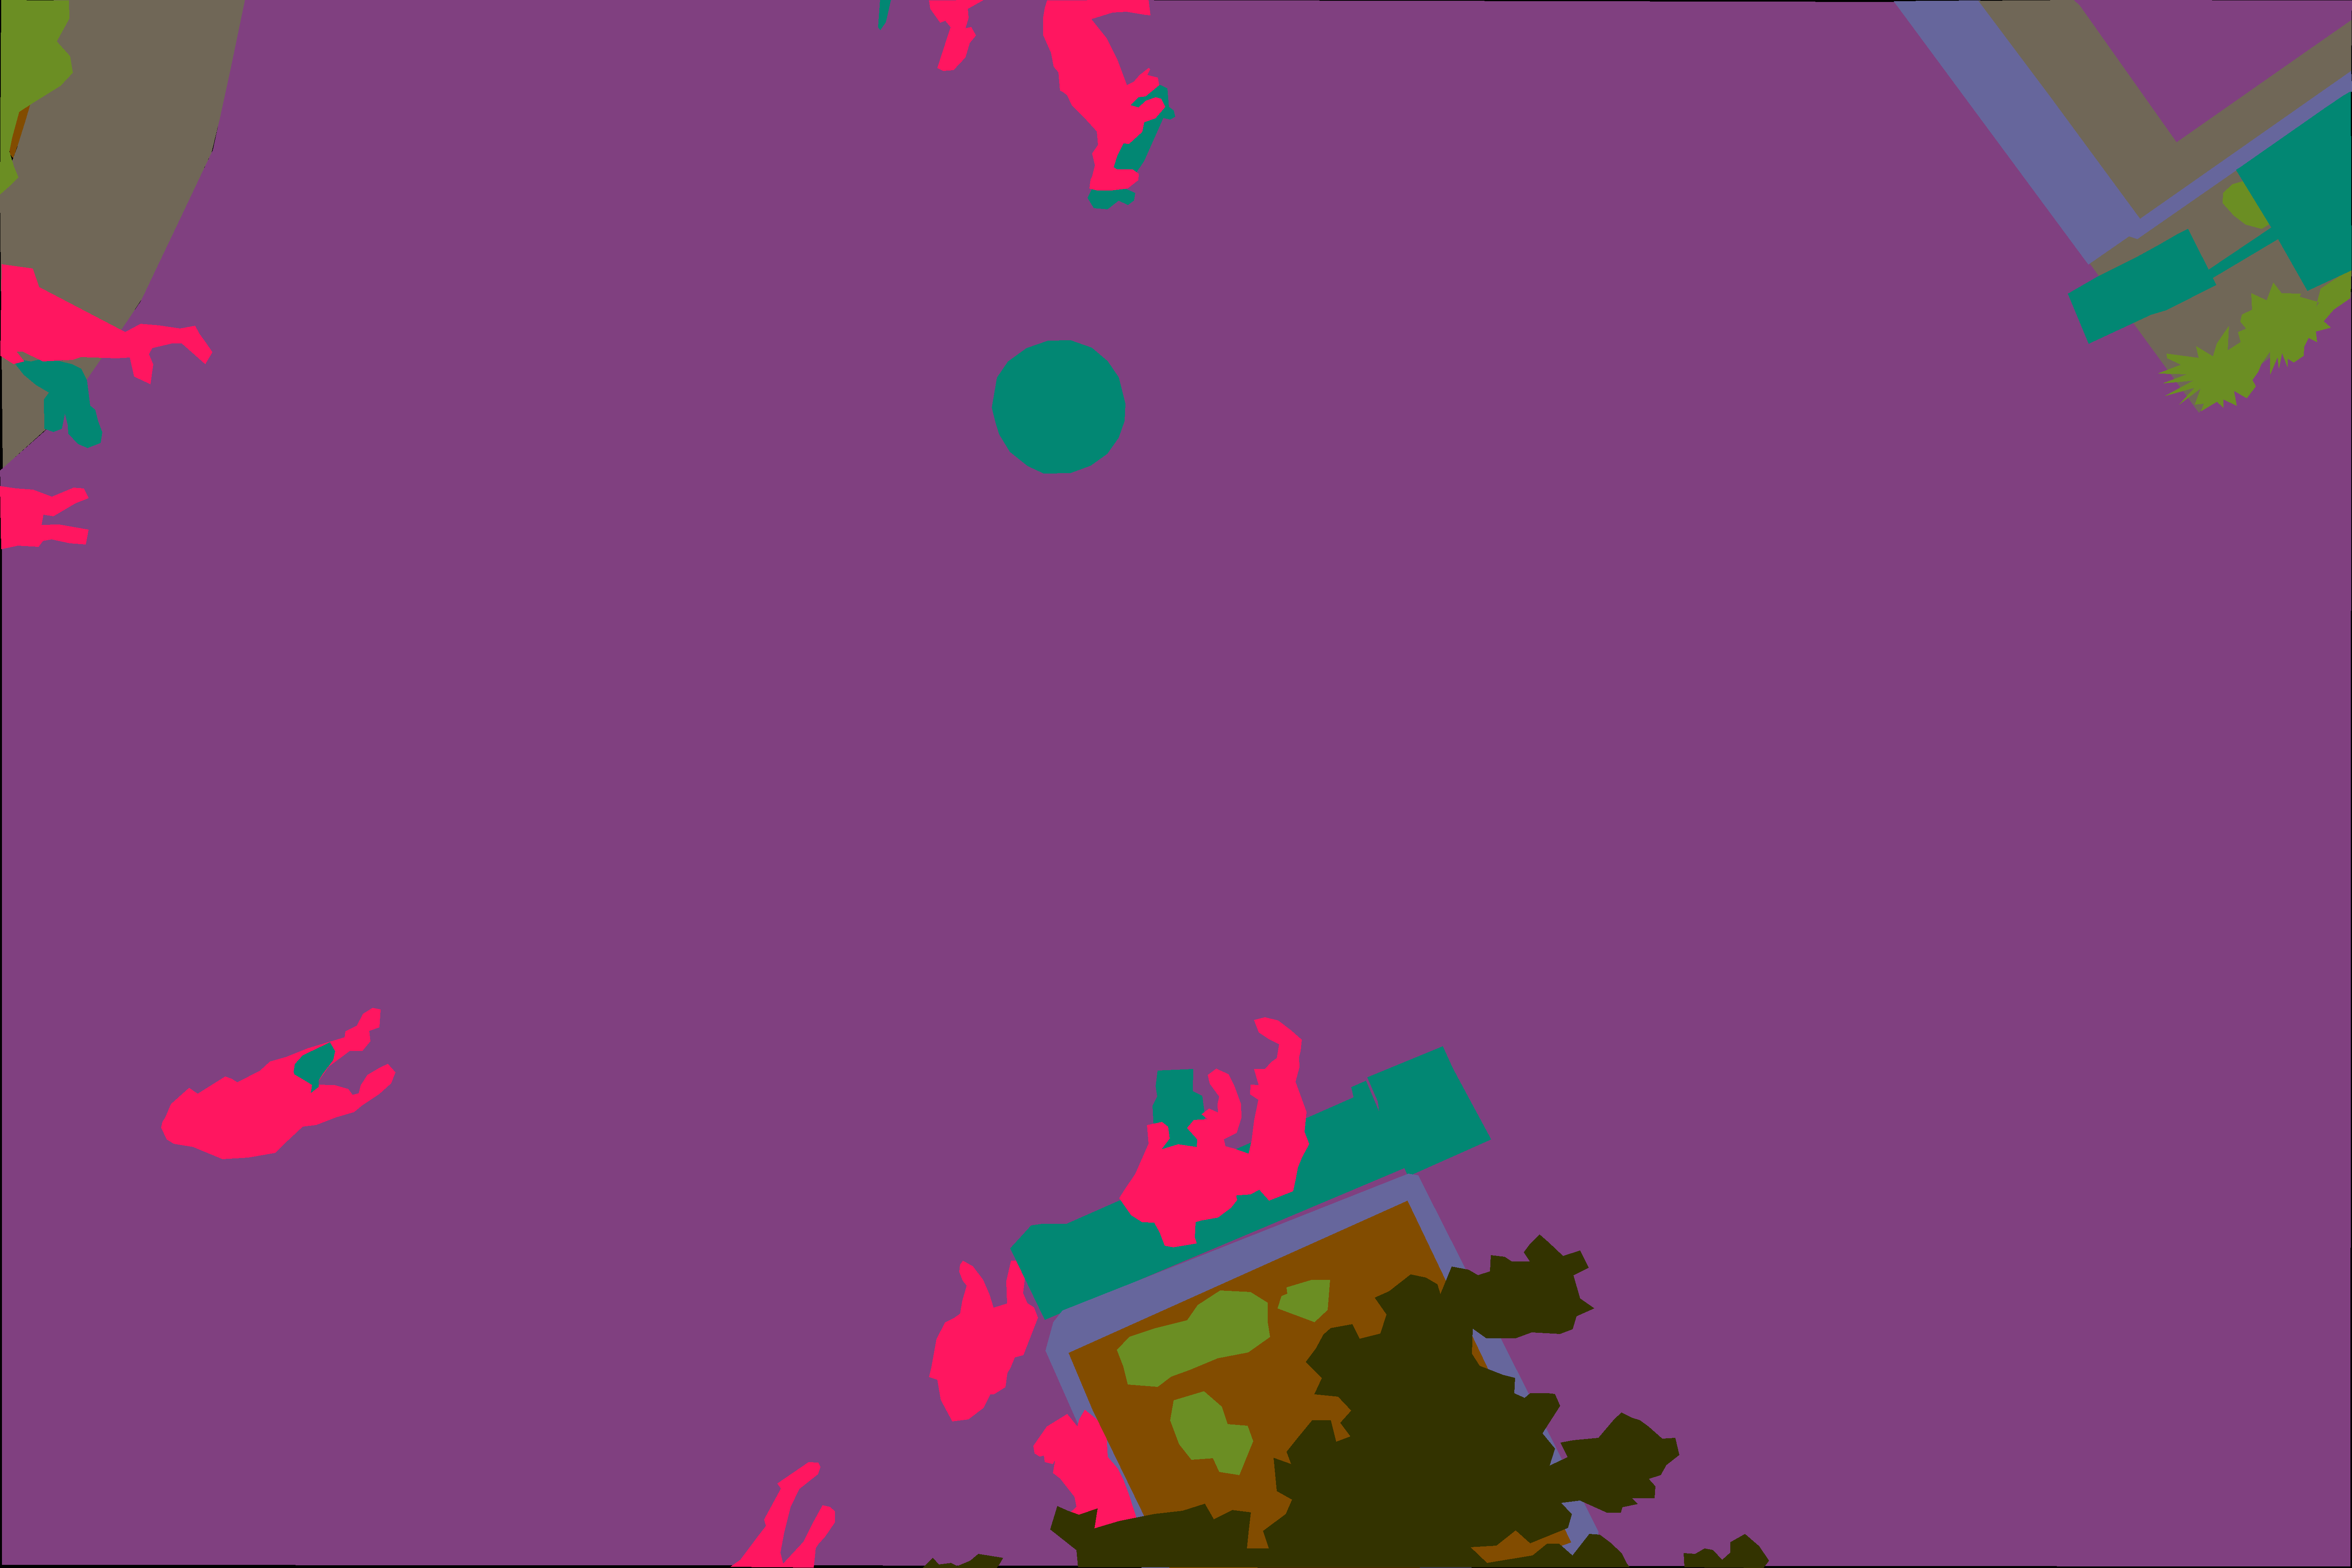

In [4]:
# index_mask = torch.from_numpy(dataset.load_numpy_label(0))
print(index_mask.size())

reverse_transform = torchvision.transforms.Compose([
    IndexMasktoColorMask(colors=dataset.mask_colors_index),
    torchvision.transforms.ToPILImage()
])

color_mask = reverse_transform(index_mask)

color_mask

In [7]:
def generate_numpy_masks():
    for idx, (_, label) in enumerate(tqdm(dataset)):

        # Path
        file_name = f'{idx:03d}.npy'
        dir_name = os.path.join(dataset.TRAINING_SEMANTICS, 'label_numpy')
        Path(dir_name).mkdir(parents=True, exist_ok=True)
        path_name = os.path.join(dir_name, file_name)

        # Transformation
        mask = transform(label)
        
        # Save tensor
        np.save(path_name, mask.numpy())
    
generate_numpy_masks()

100%|██████████| 400/400 [1:11:52<00:00, 10.78s/it]


## Visualizer

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])



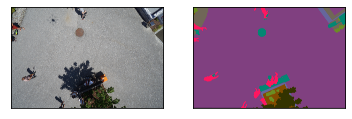

In [18]:
image, target = dataset[0]
show([image, target])